# (0) Driveのマウント と Signate API

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [4]:
# Signate APIでデータ取得
!pip install signate
!signate files --competition-id=1523
!signate download --competition-id=1523

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=e196f78219418ca2c94a5eec89c183a00610ca2bd666a543ec6db9bffc6c57ec
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00
sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


# (1) 外部ライブラリのインストール

In [5]:
# 前処理、モデルに必要
!pip install kanjize
!pip install optuna
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 4.7 MB/s eta 0:00:00


In [6]:
# EDAレポート作成時に使用
# !pip install pandas_profiling
# !pip install numba
# !pip install ydata-profiling
# !pip install pandas-profiling
# !pip install dtale
# !pip install sweetviz
# !pip install numpy==1.23.1

# (2) 前処理

In [60]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [61]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1")

# Ageの処理
for i in range(len(all_df)):
# for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10代は19歳にする
    if(-1<tmp & tmp<20):
      all_df.loc[i,"Age"] = 19
    elif(tmp>60):
      all_df.loc[i,"Age"] = 61
    else:
      # 10歳で分けて5足す
      tmp = tmp//10 * 10
      all_df.loc[i,"Age"] = tmp + 5

# int型に変換
all_df["Age"] = all_df["Age"].astype(int)

print(all_df.groupby("Age").size())

Age
-1     193
 18     17
 19     28
 20     47
 21     58
 22     81
 23     74
 24     96
 25    193
 26    123
 27    122
 28    160
 29    158
 30    194
 31    217
 32    234
 33    263
 34    234
 35    469
 36    257
 37    238
 38    206
 39    204
 40    188
 41    186
 42    198
 43    170
 44    129
 45    354
 46    146
 47    144
 48    125
 49    136
 50    165
 51    156
 52    154
 53    131
 54    131
 55    252
 56     97
 57     86
 58     63
 59     53
 60     30
 61     14
 65      4
dtype: int64


In [62]:
# 学生、定年を考慮
# カテゴリ列の追加
all_df["Age_cls"] = all_df["Age"].copy()

all_df.loc[all_df["Age"]<0,"Age_cls"] = "不明"
all_df.loc[(all_df["Age"]>=0) & (all_df["Age"]<=22),"Age_cls"] = "Student"
all_df.loc[(all_df["Age"]>=23) & (all_df["Age"]<=26),"Age_cls"] = "23~26years"
all_df.loc[(all_df["Age"]>=27) & (all_df["Age"]<=30),"Age_cls"] = "27~30years"
all_df.loc[(all_df["Age"]>=31) & (all_df["Age"]<=34),"Age_cls"] = "31~34years"
all_df.loc[(all_df["Age"]>=35) & (all_df["Age"]<=38),"Age_cls"] = "35~38years"
all_df.loc[(all_df["Age"]>=39) & (all_df["Age"]<=42),"Age_cls"] = "39~42years"
all_df.loc[(all_df["Age"]>=43) & (all_df["Age"]<=46),"Age_cls"] = "43~46years"
all_df.loc[(all_df["Age"]>=47) & (all_df["Age"]<=50),"Age_cls"] = "47~50years"
all_df.loc[(all_df["Age"]>=51) & (all_df["Age"]<=54),"Age_cls"] = "51~54years"
all_df.loc[(all_df["Age"]>=55) & (all_df["Age"]<=58),"Age_cls"] = "55~58years"
all_df.loc[all_df["Age"]>=59,"Age_cls"] = "Retire"

# 元のカラムを削除する
all_df = all_df.drop("Age",axis=1)

all_df['Age_cls'] = all_df['Age_cls'].astype('object')
print(all_df.groupby(["Age_cls"]).size())

Age_cls
23~26years     486
27~30years     634
31~34years     948
35~38years    1170
39~42years     776
43~46years     799
47~50years     570
51~54years     572
55~58years     498
Retire         101
Student        231
不明             193
dtype: int64


<ipython-input-62-1977435000>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["Age"]<0,"Age_cls"] = "不明"


In [63]:
# # カテゴリ列の追加
# all_df["Age_cls"] = all_df["Age"].copy()

# all_df.loc[all_df["Age"]<0,"Age_cls"] = "NA"
# all_df.loc[(all_df["Age"]>=10) & (all_df["Age"]<=20),"Age_cls"] = "~20years"
# all_df.loc[(all_df["Age"]>=21) & (all_df["Age"]<=25),"Age_cls"] = "21~25years"
# all_df.loc[(all_df["Age"]>=26) & (all_df["Age"]<=30),"Age_cls"] = "26~30years"
# all_df.loc[(all_df["Age"]>=31) & (all_df["Age"]<=35),"Age_cls"] = "31~35years"
# all_df.loc[(all_df["Age"]>=36) & (all_df["Age"]<=40),"Age_cls"] = "36~40years"
# all_df.loc[(all_df["Age"]>=41) & (all_df["Age"]<=45),"Age_cls"] = "41~45years"
# all_df.loc[(all_df["Age"]>=46) & (all_df["Age"]<=50),"Age_cls"] = "46~50years"
# all_df.loc[(all_df["Age"]>=51) & (all_df["Age"]<=55),"Age_cls"] = "51~55years"
# all_df.loc[all_df["Age"]>=56,"Age_cls"] = "56years~"

# # 元のカラムを削除する
# # all_df = all_df.drop("Age",axis=1)

# all_df['Age_cls'] = all_df['Age_cls'].astype('object')
# print(all_df.groupby(["Age_cls"]).size())

In [64]:
#########################
# "TypeofContact"の処理 #
#########################
print(all_df.groupby("TypeofContact").size())

TypeofContact
Company Invited    2516
Self Enquiry       4444
dtype: int64


In [65]:
#########################
# "CityTier"の処理 #
#########################
all_df["CityTier"] = all_df["CityTier"].astype("object")
print(all_df.groupby("CityTier").size())

CityTier
1    2991
2    3160
3     827
dtype: int64


In [66]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(len(all_df)):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

# int型に変換
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("int")

# 秒に換算
all_df["DurationOfPitch"] = all_df["DurationOfPitch"] * 60
print(all_df.groupby("DurationOfPitch").size())

DurationOfPitch
-60      252
 240       3
 300      43
 360     167
 420     446
 480     671
 540     654
 600     467
 660     306
 720     293
 780     397
 840     518
 900     569
 960     527
 1020    312
 1080    133
 1140     50
 1200     66
 1260     65
 1320     84
 1380    104
 1440     86
 1500     79
 1560     64
 1620     57
 1680     56
 1740     48
 1800     65
 1860     86
 1920     93
 1980     69
 2040     75
 2100     58
 2160     15
dtype: int64


In [67]:
# カテゴリ列の追加
all_df["DurationOfPitch_cls"] = all_df["DurationOfPitch"].copy()

all_df.loc[all_df["DurationOfPitch"]<0,"DurationOfPitch_cls"] = "不明"
all_df.loc[(all_df["DurationOfPitch"]>0) & (all_df["DurationOfPitch"]<=400),"DurationOfPitch_cls"] = "~400s"
all_df.loc[(all_df["DurationOfPitch"]>400) & (all_df["DurationOfPitch"]<=500),"DurationOfPitch_cls"] = "401~500s"
all_df.loc[(all_df["DurationOfPitch"]>500) & (all_df["DurationOfPitch"]<=600),"DurationOfPitch_cls"] = "501~600s"
all_df.loc[(all_df["DurationOfPitch"]>600) & (all_df["DurationOfPitch"]<=700),"DurationOfPitch_cls"] = "601~700s"
all_df.loc[(all_df["DurationOfPitch"]>700) & (all_df["DurationOfPitch"]<=800),"DurationOfPitch_cls"] = "701~800s"
all_df.loc[(all_df["DurationOfPitch"]>800) & (all_df["DurationOfPitch"]<=900),"DurationOfPitch_cls"] = "801~900s"
all_df.loc[(all_df["DurationOfPitch"]>900) & (all_df["DurationOfPitch"]<=1000),"DurationOfPitch_cls"] = "901~1000s"
all_df.loc[(all_df["DurationOfPitch"]>1000) & (all_df["DurationOfPitch"]<=1100),"DurationOfPitch_cls"] = "1001~1100s"
all_df.loc[(all_df["DurationOfPitch"]>1100) & (all_df["DurationOfPitch"]<=1200),"DurationOfPitch_cls"] = "1101~1200s"
all_df.loc[(all_df["DurationOfPitch"]>1200) & (all_df["DurationOfPitch"]<=1300),"DurationOfPitch_cls"] = "1201~1300s"
all_df.loc[(all_df["DurationOfPitch"]>1300) & (all_df["DurationOfPitch"]<=1400),"DurationOfPitch_cls"] = "1301~1400s"
all_df.loc[(all_df["DurationOfPitch"]>1400) & (all_df["DurationOfPitch"]<=1500),"DurationOfPitch_cls"] = "1401~1500s"
all_df.loc[all_df["DurationOfPitch"]>1500,"DurationOfPitch_cls"] = "1501s~"

# 元のカラムを削除
all_df = all_df.drop("DurationOfPitch", axis=1)

all_df["DurationOfPitch_cls"] = all_df["DurationOfPitch_cls"].astype("object")
print(all_df.groupby(["DurationOfPitch_cls"]).size())

DurationOfPitch_cls
1001~1100s     445
1101~1200s     116
1201~1300s      65
1301~1400s     188
1401~1500s     165
1501s~         686
401~500s      1117
501~600s      1121
601~700s       306
701~800s       690
801~900s      1087
901~1000s      527
~400s          213
不明             252
dtype: int64


<ipython-input-67-2481826810>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["DurationOfPitch"]<0,"DurationOfPitch_cls"] = "不明"


In [68]:
####################
# "Occupation"の処理 #
####################
print(all_df.groupby(["Occupation"]).size())

Occupation
Large Business     721
Salaried          2801
Small Business    3456
dtype: int64


In [69]:
##################
# "Genger"の処理 #
##################
# 先頭文字がMかmならMaleになる
for i in range(len(all_df)):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1]).lower()
  if(head == "f"):
    all_df.loc[i,"Gender"] = "Female"
  else:
    all_df.loc[i,"Gender"] = "Male"

# カテゴリ型にキャスト
all_df["Gender"] = all_df["Gender"].astype("object")
print(all_df.groupby(["Gender"]).size())

Gender
Female    2760
Male      4218
dtype: int64


In [70]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
print(all_df.groupby(["NumberOfPersonVisiting"]).size())

NumberOfPersonVisiting
1.0     686
2.0    3163
3.0    2773
4.0     356
dtype: int64


In [71]:
##################################
# "NumberOfFollowups"の処理 #
##################################
# 欠損を-1で埋める
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

# 分布の確認
print(all_df.groupby(["NumberOfFollowups"]).size())

NumberOfFollowups
-1.0      57
 1.0     178
 2.0     213
 3.0    2561
 4.0    2777
 5.0    1122
 6.0      70
dtype: int64


In [72]:
# カテゴリ列の追加
all_df["NumberOfFollowups_cls"] = all_df["NumberOfFollowups"].copy()

all_df.loc[all_df["NumberOfFollowups"]==-1,"NumberOfFollowups_cls"] = "不明"
all_df.loc[all_df["NumberOfFollowups"]==1,"NumberOfFollowups_cls"] = "1 time"
all_df.loc[all_df["NumberOfFollowups"]==2,"NumberOfFollowups_cls"] = "2 times"
all_df.loc[all_df["NumberOfFollowups"]==3,"NumberOfFollowups_cls"] = "3 times"
all_df.loc[all_df["NumberOfFollowups"]==4,"NumberOfFollowups_cls"] = "4 times"
all_df.loc[all_df["NumberOfFollowups"]==5,"NumberOfFollowups_cls"] = "5 times"
all_df.loc[all_df["NumberOfFollowups"]==6,"NumberOfFollowups_cls"] = "6 times"

# 元のカラムを削除する
all_df = all_df.drop("NumberOfFollowups", axis=1)

all_df["NumberOfFollowups_cls"] = all_df["NumberOfFollowups_cls"].astype("object")
print(all_df.groupby(["NumberOfFollowups_cls"]).size())

NumberOfFollowups_cls
1 time      178
2 times     213
3 times    2561
4 times    2777
5 times    1122
6 times      70
不明           57
dtype: int64


<ipython-input-72-3676565483>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["NumberOfFollowups"]==-1,"NumberOfFollowups_cls"] = "不明"


In [73]:
##########################
# "ProductPitched"の処理 #
##########################
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

all_df["ProductPitched"] = all_df["ProductPitched"].astype("object")

# 分布の確認
print(all_df.groupby(["ProductPitched"]).size())

ProductPitched
Basic          2347
Deluxe         2091
King            286
Standard       1614
SuperDeluxe     640
dtype: int64


In [74]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
print(all_df.groupby(["PreferredPropertyStar"]).size())

PreferredPropertyStar
3.0    4328
4.0    2254
5.0     396
dtype: int64


In [75]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips_num"] = [0]*len(all_df)
all_df["NumberOfTrips_num"] = -1

all_df["NumberOfTrips_num"] = all_df["NumberOfTrips_num"].astype(int)

all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

for i in range(len(all_df)):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"][2:3])

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"][3:4])*2

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"][4:5])*4

  elif(head == "-1"):
    all_df.loc[i,"NumberOfTrips_num"] = -1

  else:
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"])

print(all_df.groupby(["NumberOfTrips_num"]).size())

NumberOfTrips_num
-1      64
 1     801
 2    2277
 3    1706
 4     333
 5     977
 6     281
 7     513
 8      26
dtype: int64


In [76]:
# 名前を元に戻す
all_df["NumberOfTrips"] = all_df["NumberOfTrips_num"].copy()
all_df = all_df.drop("NumberOfTrips_num", axis=1)

In [77]:
#########################
# "Passport"の処理 #
#########################
print(all_df.groupby(["Passport"]).size())

Passport
0    6288
1     690
dtype: int64


In [78]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
print(all_df.groupby(["PitchSatisfactionScore"]).size())

PitchSatisfactionScore
1    1439
2    2500
3    1344
4    1452
5     243
dtype: int64


In [79]:
#########################
# "Designation"の処理 #
#########################

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

all_df["Designation"] = all_df["Designation"].astype("object")

# 分布の確認
print(all_df.groupby(["Designation"]).size())

Designation
AVP                635
Executive         2330
Manager           2117
Senior Manager    1632
VP                 264
dtype: int64


In [80]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(len(all_df)):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

print(all_df.groupby(["MonthlyIncome"]).size())

MonthlyIncome
-1.0         105
 200000.0      5
 238890.0      1
 239340.0      1
 240000.0      2
            ... 
 578460.0      1
 578490.0      1
 578670.0      1
 579015.0      1
 600000.0     10
Length: 4586, dtype: int64


In [81]:
# アルバイトの学生を考慮したい
all_df["MonthlyIncome_cls"] = all_df["MonthlyIncome"].copy()

all_df.loc[all_df["MonthlyIncome"]<=0,"MonthlyIncome_cls"] = "不明"
all_df.loc[(all_df["MonthlyIncome"]>0) & (all_df["MonthlyIncome"]<220000),"MonthlyIncome_cls"] = "220000~"
all_df.loc[(all_df["MonthlyIncome"]>=220000) & (all_df["MonthlyIncome"]<240000),"MonthlyIncome_cls"] = "220000~240000"
all_df.loc[(all_df["MonthlyIncome"]>=240000) & (all_df["MonthlyIncome"]<260000),"MonthlyIncome_cls"] = "240000~260000"
all_df.loc[(all_df["MonthlyIncome"]>=260000) & (all_df["MonthlyIncome"]<280000),"MonthlyIncome_cls"] = "260000~280000"
all_df.loc[(all_df["MonthlyIncome"]>=280000) & (all_df["MonthlyIncome"]<300000),"MonthlyIncome_cls"] = "280000~300000"
all_df.loc[(all_df["MonthlyIncome"]>=300000) & (all_df["MonthlyIncome"]<320000),"MonthlyIncome_cls"] = "300000~320000"
all_df.loc[(all_df["MonthlyIncome"]>=320000) & (all_df["MonthlyIncome"]<340000),"MonthlyIncome_cls"] = "320000~340000"
all_df.loc[(all_df["MonthlyIncome"]>=340000) & (all_df["MonthlyIncome"]<360000),"MonthlyIncome_cls"] = "340000~360000"
all_df.loc[(all_df["MonthlyIncome"]>=360000) & (all_df["MonthlyIncome"]<380000),"MonthlyIncome_cls"] = "360000~380000"
all_df.loc[(all_df["MonthlyIncome"]>=380000) & (all_df["MonthlyIncome"]<400000),"MonthlyIncome_cls"] = "380000~400000"
all_df.loc[(all_df["MonthlyIncome"]>=400000) & (all_df["MonthlyIncome"]<420000),"MonthlyIncome_cls"] = "400000~420000"
all_df.loc[(all_df["MonthlyIncome"]>=420000) & (all_df["MonthlyIncome"]<440000),"MonthlyIncome_cls"] = "420000~440000"
all_df.loc[(all_df["MonthlyIncome"]>=440000) & (all_df["MonthlyIncome"]<460000),"MonthlyIncome_cls"] = "440000~460000"
all_df.loc[(all_df["MonthlyIncome"]>=460000) & (all_df["MonthlyIncome"]<480000),"MonthlyIncome_cls"] = "460000~480000"
all_df.loc[(all_df["MonthlyIncome"]>=480000) & (all_df["MonthlyIncome"]<500000),"MonthlyIncome_cls"] = "480000~500000"
all_df.loc[(all_df["MonthlyIncome"]>=500000) & (all_df["MonthlyIncome"]<520000),"MonthlyIncome_cls"] = "500000~420000"
all_df.loc[(all_df["MonthlyIncome"]>=520000) & (all_df["MonthlyIncome"]<540000),"MonthlyIncome_cls"] = "520000~540000"
all_df.loc[(all_df["MonthlyIncome"]>=540000) & (all_df["MonthlyIncome"]<560000),"MonthlyIncome_cls"] = "540000~560000"
all_df.loc[(all_df["MonthlyIncome"]>=560000) & (all_df["MonthlyIncome"]<580000),"MonthlyIncome_cls"] = "560000~580000"
all_df.loc[all_df["MonthlyIncome"]>=580000,"MonthlyIncome_cls"] = "580000~"

# 元カラムを削除する
all_df = all_df.drop("MonthlyIncome", axis=1)

print(all_df.groupby(["MonthlyIncome_cls"]).size())

MonthlyIncome_cls
220000~             5
220000~240000       2
240000~260000     413
260000~280000     780
280000~300000     162
300000~320000    1203
320000~340000     773
340000~360000     803
360000~380000     608
380000~400000     337
400000~420000     503
420000~440000     241
440000~460000     228
460000~480000     179
480000~500000     141
500000~420000     209
520000~540000     118
540000~560000      89
560000~580000      69
580000~            10
不明                105
dtype: int64


<ipython-input-81-923969608>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["MonthlyIncome"]<=0,"MonthlyIncome_cls"] = "不明"


In [82]:
# all_df["MonthlyIncome_cls"] = all_df["MonthlyIncome"].copy()

# all_df.loc[all_df["MonthlyIncome"]<=0,"MonthlyIncome_cls"] = "NA"
# all_df.loc[(all_df["MonthlyIncome"]>0) & (all_df["MonthlyIncome"]<=250000),"MonthlyIncome_cls"] = "250000~"
# all_df.loc[(all_df["MonthlyIncome"]>250000) & (all_df["MonthlyIncome"]<=300000),"MonthlyIncome_cls"] = "250000~300000"
# all_df.loc[(all_df["MonthlyIncome"]>300000) & (all_df["MonthlyIncome"]<=350000),"MonthlyIncome_cls"] = "300000~350000"
# all_df.loc[(all_df["MonthlyIncome"]>350000) & (all_df["MonthlyIncome"]<=400000),"MonthlyIncome_cls"] = "350000~400000"
# all_df.loc[(all_df["MonthlyIncome"]>400000), "MonthlyIncome_cls"] = "400000~"

# # 元カラムを削除する
# all_df = all_df.drop("MonthlyIncome", axis=1)

# print(all_df.groupby(["MonthlyIncome_cls"]).size())

In [83]:
# ProdTaken
print(all_df.groupby(["ProdTaken"]).size())

ProdTaken
0.0    2992
1.0     497
dtype: int64


In [84]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(len(all_df)):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」、「わからない」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭") or (cont[i][-1:] == "い")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」
  else:
    c_other.append(cont[i])

In [85]:
# 新たなカラムを追加
all_df["CarHolder"] = "No" # 車所有
all_df["NumofChild"] = "NA" # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車所有",
              "車未所持","自動車未所有","車保有なし","乗用車なし","自家用車なし","車なし"]

# 子供
c_child_x = ['子育て状況不明', '子の数不詳', '子供の数不明','わからない',"子供有り"]
c_child_0 = ['子供なし', '子供無し', '無子', '子供ゼロ', '非育児家庭']
c_child_1 = ["こども1人","1児","子供1人","子供有り(1人)"]
c_child_2 = ["こども2人","2児","子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児","子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(len(all_df)):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        if(tmp[j] in ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車所有"]):
          all_df.loc[i, "CarHolder"] = "Yes"
      # 子供の情報
      if(tmp[j] in c_child_x):
        all_df.loc[i, "NumofChild"] = "NA"
      if(tmp[j] in c_child_0):
        all_df.loc[i, "NumofChild"] = "0"
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = "1"
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = "2"
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = "3"
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorced"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [86]:
# 車保有率
all_df["CarHolder"] = all_df["CarHolder"].astype("object")
print(all_df.groupby(["CarHolder"]).size())

CarHolder
No     3619
Yes    3359
dtype: int64


In [87]:
# 子供の数
all_df["NumofChild"] = all_df["NumofChild"].astype("object")
print(all_df.groupby(["NumofChild"]).size())

NumofChild
0     1909
1     2945
2     1600
3      129
NA     395
dtype: int64


In [88]:
# 婚姻歴
all_df["Married"] = all_df["Married"].astype("object")
print(all_df.groupby(["Married"]).size())

Married
Divorced    1688
Married     2846
Single      2444
dtype: int64


# (3) データエンジニアリング

In [89]:
# カラム全体
all_df.columns

Index(['id', 'TypeofContact', 'CityTier', 'Occupation', 'Gender',
       'NumberOfPersonVisiting', 'ProductPitched', 'PreferredPropertyStar',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'Designation',
       'ProdTaken', 'Age_cls', 'DurationOfPitch_cls', 'NumberOfFollowups_cls',
       'MonthlyIncome_cls', 'CarHolder', 'NumofChild', 'Married'],
      dtype='object')

In [90]:
#-------------------------
# Pandasプロファイリング
#-------------------------
# import pandas_profiling as pdp

# report = pdp.ProfileReport(all_df)
# report.to_file('Pandas-profiling_report.html')

In [91]:
# 順番を整列させる
col = ['id', 'Age_cls', 'TypeofContact', 'CityTier',
        'Gender', 'NumberOfPersonVisiting',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'ProdTaken',
       'MonthlyIncome_cls', 'Married',
       ]

#  'DurationOfPitch_cls','NumberOfFollowups_cls','Occupation',, 'NumofChild', 'CarHolder'

all_df = all_df.reindex(columns=col)

In [92]:
print(all_df.dtypes)

id                          int64
Age_cls                    object
TypeofContact              object
CityTier                   object
Gender                     object
NumberOfPersonVisiting    float64
ProductPitched             object
PreferredPropertyStar     float64
NumberOfTrips               int64
Passport                    int64
PitchSatisfactionScore      int64
Designation                object
ProdTaken                 float64
MonthlyIncome_cls          object
Married                    object
dtype: object


In [40]:
all_df.head()

,id,TypeofContact,CityTier,Occupation,Gender,NumberOfPersonVisiting,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,ProdTaken,Age_cls,DurationOfPitch_cls,NumberOfFollowups_cls,MonthlyIncome_cls,CarHolder,NumofChild,Married
0,0,Self Enquiry,2,Large Business,Male,1.0,Basic,3.0,5,1,4,Executive,1.0,47~50years,801~900s,4 times,240000~260000,No,0,Single
1,1,Company Invited,1,Salaried,Male,1.0,Standard,3.0,2,1,4,Senior Manager,0.0,55~58years,801~900s,4 times,400000~420000,Yes,0,Divorced
2,2,Self Enquiry,1,Large Business,Female,1.0,Basic,3.0,4,0,4,Executive,1.0,不明,501~600s,3 times,260000~280000,No,0,Married
3,3,Self Enquiry,2,Small Business,Female,1.0,Standard,4.0,1,0,5,Senior Manager,0.0,35~38years,1001~1100s,3 times,320000~340000,Yes,0,Divorced
4,4,Company Invited,3,Small Business,Female,1.0,Basic,4.0,4,0,4,Executive,1.0,47~50years,1001~1100s,3 times,240000~260000,Yes,0,Single


In [93]:
# 結合を戻す
train = all_df.iloc[:len(train_df)].copy()
test = all_df.iloc[len(train_df):].reset_index(drop=True).copy()

In [94]:
test.columns

Index(['id', 'Age_cls', 'TypeofContact', 'CityTier', 'Gender',
       'NumberOfPersonVisiting', 'ProductPitched', 'PreferredPropertyStar',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'Designation',
       'ProdTaken', 'MonthlyIncome_cls', 'Married'],
      dtype='object')

In [95]:
# 欠損値を最頻値で補完
train.fillna(train.mode().iloc[0], inplace=True)
test.fillna(test.mode().iloc[0], inplace=True)

<ipython-input-95-3116635073>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train.fillna(train.mode().iloc[0], inplace=True)
<ipython-input-95-3116635073>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test.fillna(test.mode().iloc[0], inplace=True)


In [96]:
# 一時的に「-1」としていた欠損値も最頻値で補完
train.loc[train["NumberOfTrips"]==-1,"NumberOfTrips"] = train.loc[train["NumberOfTrips"]>0,"NumberOfTrips"].median()
test.loc[test["NumberOfTrips"]==-1,"NumberOfTrips"] = test.loc[test["NumberOfTrips"]>0,"NumberOfTrips"].median()

In [97]:
# 一時的に「-1」としていた欠損値も最頻値で補完(必要とあらば)
# train.loc[train["Age"]==-1,"Age"] = train.loc[train["Age"]>0,"Age"].median()
# test.loc[test["Age"]==-1,"Age"] = test.loc[test["Age"]>0,"Age"].median()

# train.loc[train["DurationOfPitch"]==-60,"DurationOfPitch"] = train.loc[train["DurationOfPitch"]>0,"DurationOfPitch"].median()
# test.loc[test["DurationOfPitch"]==-60,"DurationOfPitch"] = test.loc[test["DurationOfPitch"]>0,"DurationOfPitch"].median()

# train.loc[train["NumberOfFollowups"]==-1,"NumberOfFollowups"] = train.loc[train["NumberOfFollowups"]>0,"NumberOfFollowups"].median()
# test.loc[test["NumberOfFollowups"]==-1,"NumberOfFollowups"] = test.loc[test["NumberOfFollowups"]>0,"NumberOfFollowups"].median()

# train.loc[train["MonthlyIncome"]==-1,"MonthlyIncome"] = train.loc[train["MonthlyIncome"]>0,"MonthlyIncome"].median()
# test.loc[test["MonthlyIncome"]==-1,"MonthlyIncome"] = test.loc[test["MonthlyIncome"]>0,"MonthlyIncome"].median()

In [98]:
# # 年齢ごとの平均月収を列に加える
# train["IncomePerAge"] = 0
# test["IncomePerAge"] = 0

# # 訓練データを年齢ごとの平均代入
# for cat in train["Age_cls"].unique():
#   train.loc[train["Age_cls"]==cat,"IncomePerAge"] = train.loc[train["Age_cls"]==cat,"MonthlyIncome_cls"].mode()[0]

# for cat in test["Age_cls"].unique():
#   test.loc[test["Age_cls"]==cat,"IncomePerAge"] = test.loc[test["Age_cls"]==cat,"MonthlyIncome_cls"].mode()[0]

In [99]:
# train.dtypes

In [100]:
# train.describe()

In [101]:
# test.describe()

In [102]:
# print(train.isnull().sum())

In [103]:
print(test.isnull().sum())

id                           0
Age_cls                      0
TypeofContact                0
CityTier                     0
Gender                       0
NumberOfPersonVisiting       0
ProductPitched               0
PreferredPropertyStar        0
NumberOfTrips                0
Passport                     0
PitchSatisfactionScore       0
Designation                  0
ProdTaken                 3489
MonthlyIncome_cls            0
Married                      0
dtype: int64


In [104]:
train.columns

Index(['id', 'Age_cls', 'TypeofContact', 'CityTier', 'Gender',
       'NumberOfPersonVisiting', 'ProductPitched', 'PreferredPropertyStar',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'Designation',
       'ProdTaken', 'MonthlyIncome_cls', 'Married'],
      dtype='object')

In [105]:
# # 順番を整列させる
# col = ['id', 'Age_cls', 'TypeofContact', 'CityTier',
#         'Gender', 'NumberOfPersonVisiting',
#        'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
#        'PitchSatisfactionScore', 'Designation', 'ProdTaken',
#        'MonthlyIncome_cls', 'Married', "IncomePerAge"
#        ]

# #  'DurationOfPitch_cls','NumberOfFollowups_cls','Occupation',, 'NumofChild', 'CarHolder'

# train = train.reindex(columns=col)
# test = test.reindex(columns=col)

In [106]:
# # EDAレポート作成時のみ必要
# #-------------------------
# # Sweetvis
# #-------------------------
# import dtale
# import sweetviz as sv

# test2 = test.drop("ProdTaken",axis=1)
# my_report = sv.compare([train, "Train"], [test2, "Test"], "ProdTaken")

# # 直接ブラウザに表示
# my_report.show_html("sweetviz_report_2col.html")

# 特徴量の検討

In [107]:
# 「年齢」x「独身」微妙
# train["Age_cls_Married"] = train["Age_cls"].astype(str)+"_"+train["Married"].astype(str)
# test["Age_cls_Married"] = test["Age_cls"].astype(str)+"_"+test["Married"].astype(str)

In [108]:
# 「年齢」x「婚姻」x「旅行人数」
train["Age_cls_Married_NumberOfPersonVisiting"] = train["Age_cls"].astype(str)+"_"+train["Married"].astype(str)+"_"+train["NumberOfPersonVisiting"].astype(str)
test["Age_cls_Married_NumberOfPersonVisiting"] = test["Age_cls"].astype(str)+"_"+test["Married"].astype(str)+"_"+test["NumberOfPersonVisiting"].astype(str)

In [ ]:
# # Executiveを追加
# train["Executive"] = "No"
# test["Executive"] = "No"

# # 訓練データを年齢ごとの平均代入
# for cat in train["Designation"].unique():
#   train.loc[train["Designation"]=="Executive","Executive"] = "Yes"

# for cat in test["Designation"].unique():
#   test.loc[test["Designation"]=="Executive","Executive"] = "Yes"

In [ ]:
# # Singleを追加
# train["Single"] = "No"
# test["Single"] = "No"

# # 訓練データを年齢ごとの平均代入
# for cat in train["Married"].unique():
#   train.loc[train["Married"]=="Single","Single"] = "Yes"

# for cat in test["Married"].unique():
#   test.loc[test["Married"]=="Single","Single"] = "Yes"

In [ ]:
# 「Executive」x「婚姻」x「パスポート」(独身)
# train["Executive_Married_Passport"] = train["Executive"].astype(str)+"_"+train["Married"].astype(str)+"_"+train["Passport"].astype(str)
# test["Executive_Married_Passport"] = test["Executive"].astype(str)+"_"+test["Married"].astype(str)+"_"+test["Passport"].astype(str)

# train = train.drop("Executive",axis=1)
# test = test.drop("Executive",axis=1)

In [ ]:
# train.head()

In [ ]:
# 「役職」x「婚姻」x「パスポート」(独身)ボツ
# train["Designation_Single_Passport"] = train["Designation"].astype(str)+"_"+train["Single"].astype(str)+"_"+train["Passport"].astype(str)
# test["Designation_Single_Passport"] = test["Designation"].astype(str)+"_"+test["Single"].astype(str)+"_"+test["Passport"].astype(str)

In [ ]:
# # 「Executive」x「パスポート」x「フォローアップ回数」
# train["Executive_PitchSatisfactionScore"] = train["Executive"].astype(str)+"_"+train["PitchSatisfactionScore"].astype(str)
# test["Executive_PitchSatisfactionScore"] = test["Executive"].astype(str)+"_"+test["PitchSatisfactionScore"].astype(str)

In [ ]:
# 「Executive」x「パスポート」x「フォローアップ回数」
# train["Executive_Passport_NumberOfFollowups_cls"] = train["Executive"].astype(str)+"_"+train["Passport"].astype(str)+"_"+train["NumberOfFollowups_cls"].astype(str)
# test["Executive_Passport_NumberOfFollowups_cls"] = test["Executive"].astype(str)+"_"+test["Passport"].astype(str)+"_"+test["NumberOfFollowups_cls"].astype(str)

In [ ]:
# train = train.drop("Executive",axis=1)
# test = test.drop("Executive",axis=1)

# train = train.drop("Single",axis=1)
# test = test.drop("Single",axis=1)

In [ ]:
# pd.options.display.max_rows = 1000

In [ ]:
# 「役職」と成約率を最も詳しく割り出したい
# train[["id","PitchSatisfactionScore","Executive","ProdTaken"]].groupby(["PitchSatisfactionScore","Executive","ProdTaken"]).count()
# train[["id","Executive","Passport","ProdTaken"]].groupby(["Executive","Passport","ProdTaken"]).count()
# train[["id","Executive","Passport","NumberOfFollowups_cls","ProdTaken"]].groupby(["Executive","Passport","NumberOfFollowups_cls","ProdTaken"]).count()
# train[["id","Executive","Passport","ProdTaken","Single"]].groupby(["Executive","Single","Passport","ProdTaken"]).count()
# train[["id","Executive","Passport","ProdTaken","Married"]].groupby(["Executive","Married","Passport","ProdTaken"]).count()

In [ ]:
# 「役職」と成約率を最も詳しく割り出したい
# train[["id","Designation","Passport","ProdTaken","Married"]].groupby(["Designation","Married","Passport","ProdTaken"]).count()

In [ ]:
# 「役職」x「月収」ボツ
# train["Designation_MonthlyIncome_cls"] = train["Designation"].astype(str)+"_"+train["MonthlyIncome_cls"].astype(str)
# test["Designation_MonthlyIncome_cls"] = test["Designation"].astype(str)+"_"+test["MonthlyIncome_cls"].astype(str)

In [ ]:
# 「役職」x「パスポート」ボツ
# train["Designation_Passport"] = train["Designation"].astype(str)+"_"+train["Passport"].astype(str)
# test["Designation_Passport"] = test["Designation"].astype(str)+"_"+test["Passport"].astype(str)

In [ ]:
# # 「役職」x「商品ランク」ボツ
# train["Designation_Occupation"] = train["Designation"].astype(str)+"_"+train["Occupation"].astype(str)
# test["Designation_Occupation"] = test["Designation"].astype(str)+"_"+test["Occupation"].astype(str)

In [ ]:
# train = train.drop("Occupation",axis=1)
# test = test.drop("Occupation",axis=1)

In [ ]:
# 「年齢」x「婚姻」x「パスポート」ボツ
# train["Age_cls_Married_Passport"] = train["Age_cls"].astype(str)+"_"+train["Married"].astype(str)+"_"+train["Passport"].astype(str)
# test["Age_cls_Married_Passport"] = test["Age_cls"].astype(str)+"_"+test["Married"].astype(str)+"_"+test["Passport"].astype(str)

In [ ]:
# 「年齢」x「婚姻」x「旅行ランク」ボツ
# train["Age_cls_Married_ProductPitched"] = train["Age_cls"].astype(str)+"_"+train["Married"].astype(str)+"_"+train["ProductPitched"].astype(str)
# test["Age_cls_Married_ProductPitched"] = test["Age_cls"].astype(str)+"_"+test["Married"].astype(str)+"_"+test["ProductPitched"].astype(str)

In [ ]:
# # クロス特徴量の追加
# # 「役職」x「商品ランク」
# train["Designation_ProductPitched"] = train["Designation"].astype(str)+"_"+train["ProductPitched"]
# test["Designation_ProductPitched"] = test["Designation"].astype(str)+"_"+test["ProductPitched"]

In [109]:
# 訓練データをx,yに分割
X = train.drop(["id", "ProdTaken"], axis=1)
y = train["ProdTaken"]

In [110]:
# テストデータから目的変数を落とす
test = test.drop("ProdTaken",axis=1)

In [111]:
test.columns

Index(['id', 'Age_cls', 'TypeofContact', 'CityTier', 'Gender',
       'NumberOfPersonVisiting', 'ProductPitched', 'PreferredPropertyStar',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'Designation',
       'MonthlyIncome_cls', 'Married',
       'Age_cls_Married_NumberOfPersonVisiting'],
      dtype='object')

In [112]:
# for feature in train.columns:
#     print(train.groupby(feature).size())
#     print("")

In [113]:
X.dtypes

,0
Age_cls,object
TypeofContact,object
CityTier,int64
Gender,object
NumberOfPersonVisiting,float64
ProductPitched,object
PreferredPropertyStar,float64
NumberOfTrips,int64
Passport,int64
PitchSatisfactionScore,int64


# (4) モデル構築と学習

In [114]:
# オブジェクト型を抽出する
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [115]:
# # オブジェクト型を抽出する
# categorical_features = X.select_dtypes(include=['category']).columns.tolist()

In [116]:
categorical_features

['Age_cls',
 'TypeofContact',
 'Gender',
 'ProductPitched',
 'Designation',
 'MonthlyIncome_cls',
 'Married',
 'Age_cls_Married_NumberOfPersonVisiting']

In [117]:
# カテゴリ型に変換
for feature in categorical_features:
  X[feature] = X[feature].astype("category")
  test[feature] = test[feature].astype("category")

In [118]:
categorical_features

['Age_cls',
 'TypeofContact',
 'Gender',
 'ProductPitched',
 'Designation',
 'MonthlyIncome_cls',
 'Married',
 'Age_cls_Married_NumberOfPersonVisiting']

In [119]:
# オブジェクト型を抽出する
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

In [120]:
categorical_features

['Age_cls',
 'TypeofContact',
 'Gender',
 'ProductPitched',
 'Designation',
 'MonthlyIncome_cls',
 'Married',
 'Age_cls_Married_NumberOfPersonVisiting']

In [ ]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

def objective(trial):

  # パラメータの指定
  params = {
      'iterations' : trial.suggest_int('iterations', 50, 300),
      'depth' : trial.suggest_int('depth', 4, 10),
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
      'od_wait' :trial.suggest_int('od_wait', 10, 50),
      'eval_metric' :'AUC',
  }

  # 複数シードの平均を取る
  seed = [42, 77, 2025]
  FOLDS = 5 # 分割数
  auc_score = []

  # seedを選択する
  for j, seed in enumerate(seed):

    print("#"*25)
    print(f"### seed =  {seed}")
    print("#"*25)

    oof_lgb = np.zeros(len(train))

    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

    # KFoldで学習
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
      X_train = X.iloc[train_idx, :]
      y_train = y[train_idx]
      X_val = X.iloc[val_idx, :]
      y_val = y[val_idx]

      cb_model = CatBoostClassifier(**params)

      cb_model.fit(
           X_train, y_train,
           cat_features=categorical_features,
           eval_set=(X_val, y_val),
           use_best_model=True,
           verbose=False,
          )

      # AUC算出
      auc_score.append(cb_model.get_best_score()["validation"]["AUC"])

  return sum(auc_score)/len(auc_score)

In [ ]:
study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=200)

[I 2025-06-07 04:41:56,724] A new study created in memory with name: no-name-ac2f3f23-fd7b-4c67-a52f-c80626e14800
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:42:19,597] Trial 0 finished with value: 0.8312598642449117 and parameters: {'iterations': 144, 'depth': 10, 'learning_rate': 0.1205712628744377, 'random_strength': 60, 'bagging_temperature': 0.04207988669606638, 'od_type': 'IncToDec', 'od_wait': 45}. Best is trial 0 with value: 0.8312598642449117.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:43:12,489] Trial 1 finished with value: 0.8154644143100266 and parameters: {'iterations': 200, 'depth': 8, 'learning_rate': 0.010725209743171997, 'random_strength': 97, 'bagging_temperature': 21.368329072358772, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 0 with value: 0.8312598642449117.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:43:21,851] Trial 2 finished with value: 0.8171047957967097 and parameters: {'iterations': 126, 'depth': 7, 'learning_rate': 0.04345454109729477, 'random_strength': 29, 'bagging_temperature': 2.801635158716261, 'od_type': 'Iter', 'od_wait': 25}. Best is trial 0 with value: 0.8312598642449117.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:43:28,861] Trial 3 finished with value: 0.8113824891930794 and parameters: {'iterations': 164, 'depth': 9, 'learning_rate': 0.019721610970574007, 'random_strength': 51, 'bagging_temperature': 2.342384984711291, 'od_type': 'Iter', 'od_wait': 16}. Best is trial 0 with value: 0.8312598642449117.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:43:40,637] Trial 4 finished with value: 0.8257890464133841 and parameters: {'iterations': 66, 'depth': 10, 'learning_rate': 0.26690431824362526, 'random_strength': 81, 'bagging_temperature': 0.1653693718282443, 'od_type': 'Iter', 'od_wait': 28}. Best is trial 0 with value: 0.8312598642449117.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:43:48,283] Trial 5 finished with value: 0.8107365645425091 and parameters: {'iterations': 80, 'depth': 7, 'learning_rate': 0.011240768803005551, 'random_strength': 91, 'bagging_temperature': 0.10842262717330164, 'od_type': 'IncToDec', 'od_wait': 31}. Best is trial 0 with value: 0.8312598642449117.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:44:09,744] Trial 6 finished with value: 0.8343493969516326 and parameters: {'iterations': 187, 'depth': 5, 'learning_rate': 0.27051668818999286, 'random_strength': 78, 'bagging_temperature': 57.27904470799624, 'od_type': 'IncToDec', 'od_wait': 47}. Best is trial 6 with value: 0.8343493969516326.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:44:15,662] Trial 7 finished with value: 0.8093761531240662 and parameters: {'iterations': 72, 'depth': 5, 'learning_rate': 0.011662890273931383, 'random_strength': 32, 'bagging_temperature': 0.358681649862755, 'od_type': 'Iter', 'od_wait': 24}. Best is trial 6 with value: 0.8343493969516326.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:44:28,542] Trial 8 finished with value: 0.8159474301664182 and parameters: {'iterations': 120, 'depth': 7, 'learning_rate': 0.016149614799999188, 'random_strength': 81, 'bagging_temperature': 0.01987021538542863, 'od_type': 'IncToDec', 'od_wait': 18}. Best is trial 6 with value: 0.8343493969516326.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:44:36,184] Trial 9 finished with value: 0.8160035313859079 and parameters: {'iterations': 51, 'depth': 9, 'learning_rate': 0.11069143219393454, 'random_strength': 73, 'bagging_temperature': 12.164139351417068, 'od_type': 'Iter', 'od_wait': 14}. Best is trial 6 with value: 0.8343493969516326.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:45:23,846] Trial 10 finished with value: 0.8368933495324581 and parameters: {'iterations': 268, 'depth': 4, 'learning_rate': 0.2704729722717776, 'random_strength': 1, 'bagging_temperature': 86.19793555713157, 'od_type': 'IncToDec', 'od_wait': 49}. Best is trial 10 with value: 0.8368933495324581.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:46:12,377] Trial 11 finished with value: 0.8338555662223733 and parameters: {'iterations': 279, 'depth': 4, 'learning_rate': 0.2957442500740311, 'random_strength': 1, 'bagging_temperature': 74.75302680953384, 'od_type': 'IncToDec', 'od_wait': 50}. Best is trial 10 with value: 0.8368933495324581.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:47:07,034] Trial 12 finished with value: 0.8344189229552154 and parameters: {'iterations': 244, 'depth': 5, 'learning_rate': 0.1513367004737994, 'random_strength': 0, 'bagging_temperature': 72.99575311741135, 'od_type': 'IncToDec', 'od_wait': 40}. Best is trial 10 with value: 0.8368933495324581.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:47:53,054] Trial 13 finished with value: 0.8369969498616517 and parameters: {'iterations': 270, 'depth': 4, 'learning_rate': 0.13169826009069677, 'random_strength': 1, 'bagging_temperature': 10.30143143108355, 'od_type': 'IncToDec', 'od_wait': 39}. Best is trial 13 with value: 0.8369969498616517.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:48:41,124] Trial 14 finished with value: 0.8361123303881525 and parameters: {'iterations': 297, 'depth': 4, 'learning_rate': 0.06817779343845316, 'random_strength': 18, 'bagging_temperature': 11.018260534176795, 'od_type': 'IncToDec', 'od_wait': 38}. Best is trial 13 with value: 0.8369969498616517.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:49:44,613] Trial 15 finished with value: 0.831012609300807 and parameters: {'iterations': 237, 'depth': 6, 'learning_rate': 0.1681147324452479, 'random_strength': 15, 'bagging_temperature': 3.641750863120226, 'od_type': 'IncToDec', 'od_wait': 38}. Best is trial 13 with value: 0.8369969498616517.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:50:24,286] Trial 16 finished with value: 0.8362146295310265 and parameters: {'iterations': 250, 'depth': 4, 'learning_rate': 0.06962389326536424, 'random_strength': 15, 'bagging_temperature': 23.951799715484512, 'od_type': 'IncToDec', 'od_wait': 42}. Best is trial 13 with value: 0.8369969498616517.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:51:21,331] Trial 17 finished with value: 0.8313470308224972 and parameters: {'iterations': 214, 'depth': 6, 'learning_rate': 0.1861153005978292, 'random_strength': 30, 'bagging_temperature': 4.931548267740162, 'od_type': 'IncToDec', 'od_wait': 34}. Best is trial 13 with value: 0.8369969498616517.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:52:16,787] Trial 18 finished with value: 0.8295479797650808 and parameters: {'iterations': 273, 'depth': 6, 'learning_rate': 0.03301573993465976, 'random_strength': 9, 'bagging_temperature': 1.3704331530543843, 'od_type': 'IncToDec', 'od_wait': 45}. Best is trial 13 with value: 0.8369969498616517.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:52:57,100] Trial 19 finished with value: 0.835992494181142 and parameters: {'iterations': 218, 'depth': 5, 'learning_rate': 0.08933100959339269, 'random_strength': 40, 'bagging_temperature': 0.6691354732655556, 'od_type': 'IncToDec', 'od_wait': 49}. Best is trial 13 with value: 0.8369969498616517.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:53:48,954] Trial 20 finished with value: 0.8348137255548885 and parameters: {'iterations': 300, 'depth': 4, 'learning_rate': 0.20009237852274384, 'random_strength': 20, 'bagging_temperature': 35.057527363280435, 'od_type': 'IncToDec', 'od_wait': 34}. Best is trial 13 with value: 0.8369969498616517.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:54:30,182] Trial 21 finished with value: 0.8361114234078594 and parameters: {'iterations': 260, 'depth': 4, 'learning_rate': 0.06867379208409438, 'random_strength': 9, 'bagging_temperature': 13.912134283144809, 'od_type': 'IncToDec', 'od_wait': 42}. Best is trial 13 with value: 0.8369969498616517.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:55:04,863] Trial 22 finished with value: 0.8335796108649416 and parameters: {'iterations': 240, 'depth': 4, 'learning_rate': 0.04646445642201437, 'random_strength': 8, 'bagging_temperature': 30.627410468272483, 'od_type': 'IncToDec', 'od_wait': 43}. Best is trial 13 with value: 0.8369969498616517.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:56:03,149] Trial 23 finished with value: 0.8346127991340666 and parameters: {'iterations': 265, 'depth': 5, 'learning_rate': 0.10298150553509666, 'random_strength': 1, 'bagging_temperature': 7.720478502271254, 'od_type': 'IncToDec', 'od_wait': 35}. Best is trial 13 with value: 0.8369969498616517.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:56:36,318] Trial 24 finished with value: 0.8361970537587872 and parameters: {'iterations': 222, 'depth': 4, 'learning_rate': 0.06920088699425254, 'random_strength': 21, 'bagging_temperature': 88.87454785548196, 'od_type': 'IncToDec', 'od_wait': 40}. Best is trial 13 with value: 0.8369969498616517.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:57:27,964] Trial 25 finished with value: 0.8353189789061896 and parameters: {'iterations': 251, 'depth': 5, 'learning_rate': 0.1331625855329483, 'random_strength': 45, 'bagging_temperature': 32.24870003836432, 'od_type': 'IncToDec', 'od_wait': 47}. Best is trial 13 with value: 0.8369969498616517.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:58:01,515] Trial 26 finished with value: 0.8223616566293491 and parameters: {'iterations': 283, 'depth': 6, 'learning_rate': 0.029376768765401795, 'random_strength': 10, 'bagging_temperature': 17.93369709923205, 'od_type': 'Iter', 'od_wait': 42}. Best is trial 13 with value: 0.8369969498616517.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:58:51,195] Trial 27 finished with value: 0.8345656040399454 and parameters: {'iterations': 283, 'depth': 4, 'learning_rate': 0.21113447925065743, 'random_strength': 29, 'bagging_temperature': 7.955110174517761, 'od_type': 'IncToDec', 'od_wait': 46}. Best is trial 13 with value: 0.8369969498616517.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 04:59:08,422] Trial 28 finished with value: 0.8354047552725785 and parameters: {'iterations': 175, 'depth': 5, 'learning_rate': 0.08743237435009407, 'random_strength': 22, 'bagging_temperature': 41.829389654661014, 'od_type': 'IncToDec', 'od_wait': 37}. Best is trial 13 with value: 0.8369969498616517.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:00:06,285] Trial 29 finished with value: 0.8340000825860593 and parameters: {'iterations': 226, 'depth': 6, 'learning_rate': 0.11960620062186665, 'random_strength': 37, 'bagging_temperature': 1.3445164035646555, 'od_type': 'IncToDec', 'od_wait': 44}. Best is trial 13 with value: 0.8369969498616517.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:00:48,899] Trial 30 finished with value: 0.8380733370221648 and parameters: {'iterations': 258, 'depth': 4, 'learning_rate': 0.21632462248901613, 'random_strength': 54, 'bagging_temperature': 5.893303739112591, 'od_type': 'IncToDec', 'od_wait': 10}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:01:32,126] Trial 31 finished with value: 0.8311906902707513 and parameters: {'iterations': 260, 'depth': 4, 'learning_rate': 0.23232539316541362, 'random_strength': 60, 'bagging_temperature': 6.296080566947007, 'od_type': 'IncToDec', 'od_wait': 12}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:01:49,989] Trial 32 finished with value: 0.8374307487318302 and parameters: {'iterations': 196, 'depth': 4, 'learning_rate': 0.14149006779882917, 'random_strength': 57, 'bagging_temperature': 18.060934699277617, 'od_type': 'IncToDec', 'od_wait': 10}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:03:21,040] Trial 33 finished with value: 0.8280489846999972 and parameters: {'iterations': 202, 'depth': 8, 'learning_rate': 0.14714152755652818, 'random_strength': 60, 'bagging_temperature': 2.297054944366951, 'od_type': 'IncToDec', 'od_wait': 10}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:03:37,097] Trial 34 finished with value: 0.8337281801963516 and parameters: {'iterations': 147, 'depth': 5, 'learning_rate': 0.2275319114439621, 'random_strength': 53, 'bagging_temperature': 18.939527398235917, 'od_type': 'IncToDec', 'od_wait': 20}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:03:48,013] Trial 35 finished with value: 0.8300125241580202 and parameters: {'iterations': 195, 'depth': 4, 'learning_rate': 0.1619289624599131, 'random_strength': 66, 'bagging_temperature': 47.6013873344158, 'od_type': 'Iter', 'od_wait': 23}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:05:46,666] Trial 36 finished with value: 0.8212534971191789 and parameters: {'iterations': 233, 'depth': 8, 'learning_rate': 0.24491467297427177, 'random_strength': 55, 'bagging_temperature': 3.763255195270299, 'od_type': 'IncToDec', 'od_wait': 10}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:05:57,982] Trial 37 finished with value: 0.8340195299204516 and parameters: {'iterations': 164, 'depth': 5, 'learning_rate': 0.19198629359987077, 'random_strength': 47, 'bagging_temperature': 9.410912173570104, 'od_type': 'Iter', 'od_wait': 28}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:06:19,482] Trial 38 finished with value: 0.8251045280546986 and parameters: {'iterations': 99, 'depth': 9, 'learning_rate': 0.2908967706491396, 'random_strength': 68, 'bagging_temperature': 2.267476395516257, 'od_type': 'IncToDec', 'od_wait': 14}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:07:05,613] Trial 39 finished with value: 0.8352573914945985 and parameters: {'iterations': 292, 'depth': 4, 'learning_rate': 0.13126627625684192, 'random_strength': 100, 'bagging_temperature': 0.3585235187854954, 'od_type': 'IncToDec', 'od_wait': 31}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:07:25,476] Trial 40 finished with value: 0.8247934378279157 and parameters: {'iterations': 209, 'depth': 5, 'learning_rate': 0.10120021651496361, 'random_strength': 41, 'bagging_temperature': 96.95998576250608, 'od_type': 'Iter', 'od_wait': 20}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:08:06,553] Trial 41 finished with value: 0.8359713213940548 and parameters: {'iterations': 255, 'depth': 4, 'learning_rate': 0.08543463781089938, 'random_strength': 14, 'bagging_temperature': 23.368993103112484, 'od_type': 'IncToDec', 'od_wait': 15}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:08:49,133] Trial 42 finished with value: 0.835787833969949 and parameters: {'iterations': 273, 'depth': 4, 'learning_rate': 0.055174022207394036, 'random_strength': 6, 'bagging_temperature': 21.256842168898142, 'od_type': 'IncToDec', 'od_wait': 48}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:09:29,997] Trial 43 finished with value: 0.8344132993578083 and parameters: {'iterations': 247, 'depth': 4, 'learning_rate': 0.17452534123176772, 'random_strength': 89, 'bagging_temperature': 53.24170136043671, 'od_type': 'IncToDec', 'od_wait': 29}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:09:49,534] Trial 44 finished with value: 0.8326259734434591 and parameters: {'iterations': 190, 'depth': 5, 'learning_rate': 0.24739166753083824, 'random_strength': 4, 'bagging_temperature': 27.42523388725497, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:10:32,831] Trial 45 finished with value: 0.835879895176803 and parameters: {'iterations': 267, 'depth': 4, 'learning_rate': 0.14608463539217786, 'random_strength': 56, 'bagging_temperature': 0.010381902110866264, 'od_type': 'IncToDec', 'od_wait': 50}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:11:15,251] Trial 46 finished with value: 0.8357882203177988 and parameters: {'iterations': 286, 'depth': 4, 'learning_rate': 0.05638592495122268, 'random_strength': 26, 'bagging_temperature': 13.145825788715195, 'od_type': 'IncToDec', 'od_wait': 40}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:14:31,671] Trial 47 finished with value: 0.829609311767111 and parameters: {'iterations': 230, 'depth': 10, 'learning_rate': 0.11475837177567152, 'random_strength': 66, 'bagging_temperature': 0.07928976578248285, 'od_type': 'IncToDec', 'od_wait': 26}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:14:45,871] Trial 48 finished with value: 0.821422229950683 and parameters: {'iterations': 247, 'depth': 7, 'learning_rate': 0.2658440494295498, 'random_strength': 49, 'bagging_temperature': 59.0740170872426, 'od_type': 'Iter', 'od_wait': 12}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:14:59,340] Trial 49 finished with value: 0.8205209979614421 and parameters: {'iterations': 147, 'depth': 5, 'learning_rate': 0.025730593268403747, 'random_strength': 13, 'bagging_temperature': 5.068710098236064, 'od_type': 'IncToDec', 'od_wait': 36}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:15:16,271] Trial 50 finished with value: 0.8320789915634947 and parameters: {'iterations': 179, 'depth': 4, 'learning_rate': 0.04343960682479345, 'random_strength': 4, 'bagging_temperature': 11.56491296725595, 'od_type': 'IncToDec', 'od_wait': 32}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:15:49,237] Trial 51 finished with value: 0.8362684495855723 and parameters: {'iterations': 227, 'depth': 4, 'learning_rate': 0.07036072194802717, 'random_strength': 23, 'bagging_temperature': 91.22932887038964, 'od_type': 'IncToDec', 'od_wait': 40}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:16:19,689] Trial 52 finished with value: 0.8351077261730524 and parameters: {'iterations': 207, 'depth': 4, 'learning_rate': 0.07034197158539553, 'random_strength': 35, 'bagging_temperature': 40.959773751559034, 'od_type': 'IncToDec', 'od_wait': 39}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:16:51,256] Trial 53 finished with value: 0.8251971088036268 and parameters: {'iterations': 235, 'depth': 4, 'learning_rate': 0.039606638290212964, 'random_strength': 16, 'bagging_temperature': 72.25966536747916, 'od_type': 'IncToDec', 'od_wait': 45}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:17:44,587] Trial 54 finished with value: 0.833851148544986 and parameters: {'iterations': 271, 'depth': 5, 'learning_rate': 0.07721266466656676, 'random_strength': 12, 'bagging_temperature': 19.361708802001818, 'od_type': 'IncToDec', 'od_wait': 42}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:18:19,892] Trial 55 finished with value: 0.8346913157008243 and parameters: {'iterations': 218, 'depth': 4, 'learning_rate': 0.21053969621855523, 'random_strength': 60, 'bagging_temperature': 63.783305114592075, 'od_type': 'IncToDec', 'od_wait': 12}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:19:05,475] Trial 56 finished with value: 0.8359636097022319 and parameters: {'iterations': 254, 'depth': 5, 'learning_rate': 0.059127655367335295, 'random_strength': 26, 'bagging_temperature': 29.34314538772106, 'od_type': 'IncToDec', 'od_wait': 48}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:19:43,271] Trial 57 finished with value: 0.8358793794792198 and parameters: {'iterations': 239, 'depth': 4, 'learning_rate': 0.09646161643955227, 'random_strength': 3, 'bagging_temperature': 15.044432750329376, 'od_type': 'IncToDec', 'od_wait': 44}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:20:32,627] Trial 58 finished with value: 0.8360892748814285 and parameters: {'iterations': 277, 'depth': 4, 'learning_rate': 0.1782092154213992, 'random_strength': 0, 'bagging_temperature': 5.853018082026996, 'od_type': 'IncToDec', 'od_wait': 33}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:21:40,085] Trial 59 finished with value: 0.832957424846733 and parameters: {'iterations': 264, 'depth': 6, 'learning_rate': 0.1312490850121246, 'random_strength': 18, 'bagging_temperature': 3.5927798258675683, 'od_type': 'IncToDec', 'od_wait': 41}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:22:04,248] Trial 60 finished with value: 0.8210033053223154 and parameters: {'iterations': 255, 'depth': 5, 'learning_rate': 0.017919363804157453, 'random_strength': 8, 'bagging_temperature': 89.38296779121737, 'od_type': 'Iter', 'od_wait': 38}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:22:38,825] Trial 61 finished with value: 0.8349253519593941 and parameters: {'iterations': 243, 'depth': 4, 'learning_rate': 0.06220968385965589, 'random_strength': 22, 'bagging_temperature': 96.41606771941241, 'od_type': 'IncToDec', 'od_wait': 40}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:23:12,175] Trial 62 finished with value: 0.8334526140348889 and parameters: {'iterations': 221, 'depth': 4, 'learning_rate': 0.06603793876348907, 'random_strength': 43, 'bagging_temperature': 42.39435789313574, 'od_type': 'IncToDec', 'od_wait': 36}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:23:42,652] Trial 63 finished with value: 0.8274947614062805 and parameters: {'iterations': 224, 'depth': 4, 'learning_rate': 0.04904755227172151, 'random_strength': 34, 'bagging_temperature': 61.18550657194339, 'od_type': 'IncToDec', 'od_wait': 46}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:24:12,898] Trial 64 finished with value: 0.833575564542829 and parameters: {'iterations': 210, 'depth': 4, 'learning_rate': 0.07314566848976865, 'random_strength': 72, 'bagging_temperature': 34.56051099149444, 'od_type': 'IncToDec', 'od_wait': 39}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:24:30,459] Trial 65 finished with value: 0.8353450395359374 and parameters: {'iterations': 199, 'depth': 4, 'learning_rate': 0.07993888886767467, 'random_strength': 24, 'bagging_temperature': 15.116806487612546, 'od_type': 'IncToDec', 'od_wait': 44}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:25:32,767] Trial 66 finished with value: 0.8296708223922784 and parameters: {'iterations': 290, 'depth': 5, 'learning_rate': 0.29740085185686405, 'random_strength': 19, 'bagging_temperature': 23.718411048511538, 'od_type': 'IncToDec', 'od_wait': 42}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:26:10,528] Trial 67 finished with value: 0.8362144168902536 and parameters: {'iterations': 227, 'depth': 4, 'learning_rate': 0.14840809403627128, 'random_strength': 10, 'bagging_temperature': 7.235717974884989, 'od_type': 'IncToDec', 'od_wait': 37}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:26:26,635] Trial 68 finished with value: 0.8153640304568663 and parameters: {'iterations': 184, 'depth': 4, 'learning_rate': 0.013288323835055417, 'random_strength': 11, 'bagging_temperature': 9.379383839099713, 'od_type': 'IncToDec', 'od_wait': 38}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:27:23,142] Trial 69 finished with value: 0.8349871974970688 and parameters: {'iterations': 259, 'depth': 5, 'learning_rate': 0.16647756019144433, 'random_strength': 5, 'bagging_temperature': 1.777071078053132, 'od_type': 'IncToDec', 'od_wait': 34}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:30:11,735] Trial 70 finished with value: 0.831114034879441 and parameters: {'iterations': 233, 'depth': 9, 'learning_rate': 0.10975006322650821, 'random_strength': 7, 'bagging_temperature': 6.879373046119659, 'od_type': 'IncToDec', 'od_wait': 36}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:30:27,512] Trial 71 finished with value: 0.8361161116941765 and parameters: {'iterations': 167, 'depth': 4, 'learning_rate': 0.15319685515760723, 'random_strength': 16, 'bagging_temperature': 0.6377416440877197, 'od_type': 'IncToDec', 'od_wait': 43}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:31:03,190] Trial 72 finished with value: 0.8356342743293822 and parameters: {'iterations': 225, 'depth': 4, 'learning_rate': 0.20219372934081914, 'random_strength': 51, 'bagging_temperature': 4.0084964098081475, 'od_type': 'IncToDec', 'od_wait': 41}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:31:39,156] Trial 73 finished with value: 0.8359674334950519 and parameters: {'iterations': 216, 'depth': 4, 'learning_rate': 0.09465498636511657, 'random_strength': 9, 'bagging_temperature': 77.80685554272495, 'od_type': 'IncToDec', 'od_wait': 11}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:32:25,427] Trial 74 finished with value: 0.8372377601510212 and parameters: {'iterations': 278, 'depth': 4, 'learning_rate': 0.12496506608636551, 'random_strength': 2, 'bagging_temperature': 48.19772206954592, 'od_type': 'IncToDec', 'od_wait': 40}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:34:11,804] Trial 75 finished with value: 0.8315200482875593 and parameters: {'iterations': 279, 'depth': 7, 'learning_rate': 0.13589098223962448, 'random_strength': 1, 'bagging_temperature': 8.832596510546766, 'od_type': 'IncToDec', 'od_wait': 39}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:35:02,876] Trial 76 finished with value: 0.8363476104382686 and parameters: {'iterations': 295, 'depth': 4, 'learning_rate': 0.12420217871927045, 'random_strength': 2, 'bagging_temperature': 47.17807051402194, 'od_type': 'IncToDec', 'od_wait': 47}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:35:31,350] Trial 77 finished with value: 0.836617817670623 and parameters: {'iterations': 291, 'depth': 4, 'learning_rate': 0.11911099459009901, 'random_strength': 3, 'bagging_temperature': 48.661467002652394, 'od_type': 'Iter', 'od_wait': 50}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:36:00,015] Trial 78 finished with value: 0.8356742673664356 and parameters: {'iterations': 300, 'depth': 5, 'learning_rate': 0.11969485578299802, 'random_strength': 2, 'bagging_temperature': 44.03629370664744, 'od_type': 'Iter', 'od_wait': 50}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:36:14,620] Trial 79 finished with value: 0.8351317213993413 and parameters: {'iterations': 281, 'depth': 4, 'learning_rate': 0.22514176680711914, 'random_strength': 0, 'bagging_temperature': 36.98607844013859, 'od_type': 'Iter', 'od_wait': 48}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:36:42,516] Trial 80 finished with value: 0.8353883708601717 and parameters: {'iterations': 290, 'depth': 4, 'learning_rate': 0.1081717760410934, 'random_strength': 6, 'bagging_temperature': 52.78738625773308, 'od_type': 'Iter', 'od_wait': 46}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:37:12,253] Trial 81 finished with value: 0.8366763504225941 and parameters: {'iterations': 268, 'depth': 4, 'learning_rate': 0.1380817977357923, 'random_strength': 58, 'bagging_temperature': 25.860704278581366, 'od_type': 'Iter', 'od_wait': 49}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:37:39,780] Trial 82 finished with value: 0.8351829586514932 and parameters: {'iterations': 295, 'depth': 4, 'learning_rate': 0.1285514936241468, 'random_strength': 63, 'bagging_temperature': 30.185329783338908, 'od_type': 'Iter', 'od_wait': 49}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:37:59,597] Trial 83 finished with value: 0.8342753422598093 and parameters: {'iterations': 272, 'depth': 4, 'learning_rate': 0.19207382617273577, 'random_strength': 52, 'bagging_temperature': 16.948755283939512, 'od_type': 'Iter', 'od_wait': 47}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:38:25,307] Trial 84 finished with value: 0.8338957327409094 and parameters: {'iterations': 284, 'depth': 4, 'learning_rate': 0.1657413132860959, 'random_strength': 59, 'bagging_temperature': 74.10342740312093, 'od_type': 'Iter', 'od_wait': 49}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:38:52,682] Trial 85 finished with value: 0.829707693730812 and parameters: {'iterations': 266, 'depth': 5, 'learning_rate': 0.12378918129604823, 'random_strength': 57, 'bagging_temperature': 49.080844202067645, 'od_type': 'Iter', 'od_wait': 50}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:39:10,488] Trial 86 finished with value: 0.8347789521710912 and parameters: {'iterations': 275, 'depth': 4, 'learning_rate': 0.2735647429936492, 'random_strength': 48, 'bagging_temperature': 22.44185724858287, 'od_type': 'Iter', 'od_wait': 47}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:39:39,441] Trial 87 finished with value: 0.8364600981027636 and parameters: {'iterations': 288, 'depth': 4, 'learning_rate': 0.10204791040431746, 'random_strength': 3, 'bagging_temperature': 25.975917712312697, 'od_type': 'Iter', 'od_wait': 46}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:40:05,468] Trial 88 finished with value: 0.8304363524394011 and parameters: {'iterations': 288, 'depth': 4, 'learning_rate': 0.10356871849362602, 'random_strength': 63, 'bagging_temperature': 28.67071760058591, 'od_type': 'Iter', 'od_wait': 45}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:40:32,853] Trial 89 finished with value: 0.8335445856622817 and parameters: {'iterations': 294, 'depth': 5, 'learning_rate': 0.1452048098533855, 'random_strength': 3, 'bagging_temperature': 18.62384414419713, 'od_type': 'Iter', 'od_wait': 49}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:41:01,806] Trial 90 finished with value: 0.8313967051715474 and parameters: {'iterations': 260, 'depth': 4, 'learning_rate': 0.09054489055809344, 'random_strength': 54, 'bagging_temperature': 12.130639989269909, 'od_type': 'Iter', 'od_wait': 47}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:41:30,294] Trial 91 finished with value: 0.8347942134563314 and parameters: {'iterations': 267, 'depth': 4, 'learning_rate': 0.11850731938482897, 'random_strength': 5, 'bagging_temperature': 63.72631329759357, 'od_type': 'Iter', 'od_wait': 48}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:41:48,609] Trial 92 finished with value: 0.8353188587963938 and parameters: {'iterations': 300, 'depth': 4, 'learning_rate': 0.11201160642417497, 'random_strength': 0, 'bagging_temperature': 25.69113175258976, 'od_type': 'Iter', 'od_wait': 45}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:42:02,509] Trial 93 finished with value: 0.8305481810227762 and parameters: {'iterations': 280, 'depth': 4, 'learning_rate': 0.13540621661278812, 'random_strength': 7, 'bagging_temperature': 36.35814664712461, 'od_type': 'Iter', 'od_wait': 13}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:42:15,438] Trial 94 finished with value: 0.8377854455164465 and parameters: {'iterations': 133, 'depth': 4, 'learning_rate': 0.09910161258916687, 'random_strength': 3, 'bagging_temperature': 50.607692660649754, 'od_type': 'Iter', 'od_wait': 43}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:42:27,890] Trial 95 finished with value: 0.8364075834080189 and parameters: {'iterations': 128, 'depth': 4, 'learning_rate': 0.08313218818055826, 'random_strength': 3, 'bagging_temperature': 48.85267507588781, 'od_type': 'Iter', 'od_wait': 43}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:42:39,531] Trial 96 finished with value: 0.8347784010741114 and parameters: {'iterations': 124, 'depth': 5, 'learning_rate': 0.08132190443030869, 'random_strength': 4, 'bagging_temperature': 34.817647947513535, 'od_type': 'Iter', 'od_wait': 44}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:42:50,913] Trial 97 finished with value: 0.836592590073464 and parameters: {'iterations': 129, 'depth': 4, 'learning_rate': 0.10155578910422283, 'random_strength': 13, 'bagging_temperature': 11.26181349445066, 'od_type': 'Iter', 'od_wait': 43}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:43:01,864] Trial 98 finished with value: 0.8279434793455988 and parameters: {'iterations': 138, 'depth': 4, 'learning_rate': 0.09702577632636379, 'random_strength': 13, 'bagging_temperature': 17.015341380696963, 'od_type': 'Iter', 'od_wait': 22}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:43:08,065] Trial 99 finished with value: 0.8267413292486604 and parameters: {'iterations': 104, 'depth': 4, 'learning_rate': 0.15897821435137047, 'random_strength': 11, 'bagging_temperature': 10.210536332158192, 'od_type': 'Iter', 'od_wait': 10}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:43:16,935] Trial 100 finished with value: 0.8226483216672301 and parameters: {'iterations': 114, 'depth': 10, 'learning_rate': 0.10394438202492906, 'random_strength': 46, 'bagging_temperature': 21.495281563802745, 'od_type': 'Iter', 'od_wait': 16}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:43:29,065] Trial 101 finished with value: 0.8354970129996624 and parameters: {'iterations': 154, 'depth': 4, 'learning_rate': 0.1840737327047893, 'random_strength': 7, 'bagging_temperature': 13.24097581067618, 'od_type': 'Iter', 'od_wait': 41}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:43:42,177] Trial 102 finished with value: 0.8362401794920485 and parameters: {'iterations': 140, 'depth': 4, 'learning_rate': 0.08753050279871347, 'random_strength': 3, 'bagging_temperature': 55.82934820253368, 'od_type': 'Iter', 'od_wait': 44}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:43:51,507] Trial 103 finished with value: 0.8376348374862203 and parameters: {'iterations': 115, 'depth': 4, 'learning_rate': 0.25109486250950935, 'random_strength': 5, 'bagging_temperature': 70.77794505606985, 'od_type': 'Iter', 'od_wait': 43}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:43:59,577] Trial 104 finished with value: 0.8339690727051908 and parameters: {'iterations': 92, 'depth': 4, 'learning_rate': 0.26517276606803153, 'random_strength': 9, 'bagging_temperature': 77.34584583865811, 'od_type': 'Iter', 'od_wait': 26}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:44:10,873] Trial 105 finished with value: 0.8335015980957042 and parameters: {'iterations': 131, 'depth': 4, 'learning_rate': 0.24889142527032423, 'random_strength': 57, 'bagging_temperature': 25.676937424241626, 'od_type': 'Iter', 'od_wait': 46}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:44:18,951] Trial 106 finished with value: 0.8361255168232015 and parameters: {'iterations': 97, 'depth': 4, 'learning_rate': 0.22600536363368573, 'random_strength': 8, 'bagging_temperature': 66.0833183121257, 'od_type': 'Iter', 'od_wait': 49}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:44:28,093] Trial 107 finished with value: 0.8341069912924814 and parameters: {'iterations': 80, 'depth': 4, 'learning_rate': 0.13744242431896572, 'random_strength': 5, 'bagging_temperature': 39.74328236284038, 'od_type': 'Iter', 'od_wait': 42}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:44:36,583] Trial 108 finished with value: 0.8329369272237095 and parameters: {'iterations': 116, 'depth': 5, 'learning_rate': 0.21086467240952061, 'random_strength': 0, 'bagging_temperature': 10.882092277582943, 'od_type': 'Iter', 'od_wait': 43}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:44:45,896] Trial 109 finished with value: 0.8351095769053959 and parameters: {'iterations': 109, 'depth': 4, 'learning_rate': 0.14166919944212591, 'random_strength': 63, 'bagging_temperature': 5.6665071852125495, 'od_type': 'Iter', 'od_wait': 45}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:45:10,253] Trial 110 finished with value: 0.8350746434253365 and parameters: {'iterations': 251, 'depth': 4, 'learning_rate': 0.15590274773913523, 'random_strength': 11, 'bagging_temperature': 29.57786482951588, 'od_type': 'Iter', 'od_wait': 48}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:45:22,847] Trial 111 finished with value: 0.835550738398891 and parameters: {'iterations': 128, 'depth': 4, 'learning_rate': 0.11533375272391402, 'random_strength': 2, 'bagging_temperature': 83.99637102438261, 'od_type': 'Iter', 'od_wait': 46}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:45:40,339] Trial 112 finished with value: 0.8346816538650754 and parameters: {'iterations': 137, 'depth': 8, 'learning_rate': 0.09353370381335058, 'random_strength': 5, 'bagging_temperature': 50.011903533728244, 'od_type': 'Iter', 'od_wait': 43}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:45:53,318] Trial 113 finished with value: 0.8368274417307227 and parameters: {'iterations': 154, 'depth': 4, 'learning_rate': 0.10754235020781572, 'random_strength': 2, 'bagging_temperature': 98.73443443407109, 'od_type': 'Iter', 'od_wait': 41}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:46:06,564] Trial 114 finished with value: 0.8341904103654849 and parameters: {'iterations': 148, 'depth': 4, 'learning_rate': 0.1767312360864877, 'random_strength': 50, 'bagging_temperature': 61.347091973283455, 'od_type': 'Iter', 'od_wait': 41}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:46:17,344] Trial 115 finished with value: 0.8349347967176957 and parameters: {'iterations': 123, 'depth': 4, 'learning_rate': 0.10084207211375695, 'random_strength': 6, 'bagging_temperature': 99.26913575210139, 'od_type': 'Iter', 'od_wait': 50}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:46:25,752] Trial 116 finished with value: 0.8364609773350428 and parameters: {'iterations': 156, 'depth': 4, 'learning_rate': 0.23894126325908147, 'random_strength': 0, 'bagging_temperature': 0.20641727099292784, 'od_type': 'Iter', 'od_wait': 42}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:46:35,053] Trial 117 finished with value: 0.8364564109444708 and parameters: {'iterations': 158, 'depth': 4, 'learning_rate': 0.24544232825716716, 'random_strength': 0, 'bagging_temperature': 0.4110693880941991, 'od_type': 'Iter', 'od_wait': 39}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:46:43,871] Trial 118 finished with value: 0.8355692135000402 and parameters: {'iterations': 172, 'depth': 4, 'learning_rate': 0.2628569739701813, 'random_strength': 14, 'bagging_temperature': 0.1043632102332523, 'od_type': 'Iter', 'od_wait': 42}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:46:54,652] Trial 119 finished with value: 0.8367869894226866 and parameters: {'iterations': 158, 'depth': 4, 'learning_rate': 0.2985487807325879, 'random_strength': 9, 'bagging_temperature': 0.5979429450839806, 'od_type': 'Iter', 'od_wait': 40}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:47:09,557] Trial 120 finished with value: 0.8315561326803975 and parameters: {'iterations': 134, 'depth': 5, 'learning_rate': 0.2833583966521606, 'random_strength': 17, 'bagging_temperature': 0.5181662365124469, 'od_type': 'IncToDec', 'od_wait': 37}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:47:20,950] Trial 121 finished with value: 0.8347555117264777 and parameters: {'iterations': 161, 'depth': 4, 'learning_rate': 0.2296540096248266, 'random_strength': 9, 'bagging_temperature': 0.17116354770729153, 'od_type': 'Iter', 'od_wait': 40}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:47:31,396] Trial 122 finished with value: 0.8342375659337262 and parameters: {'iterations': 145, 'depth': 4, 'learning_rate': 0.2898377134423534, 'random_strength': 7, 'bagging_temperature': 0.13761062815431307, 'od_type': 'Iter', 'od_wait': 41}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:47:38,149] Trial 123 finished with value: 0.8336212964838211 and parameters: {'iterations': 157, 'depth': 4, 'learning_rate': 0.24678971363915003, 'random_strength': 1, 'bagging_temperature': 0.807762625767713, 'od_type': 'Iter', 'od_wait': 38}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:47:50,210] Trial 124 finished with value: 0.8361544067539567 and parameters: {'iterations': 168, 'depth': 4, 'learning_rate': 0.2056379174166496, 'random_strength': 86, 'bagging_temperature': 0.26437780871548394, 'od_type': 'Iter', 'od_wait': 30}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:48:02,142] Trial 125 finished with value: 0.8349282123923192 and parameters: {'iterations': 119, 'depth': 4, 'learning_rate': 0.19100923843837878, 'random_strength': 55, 'bagging_temperature': 0.051832712477097975, 'od_type': 'Iter', 'od_wait': 40}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:48:16,750] Trial 126 finished with value: 0.8371632399655916 and parameters: {'iterations': 151, 'depth': 4, 'learning_rate': 0.12884244011616197, 'random_strength': 4, 'bagging_temperature': 0.31558730763217996, 'od_type': 'IncToDec', 'od_wait': 42}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:48:31,111] Trial 127 finished with value: 0.8355796112221314 and parameters: {'iterations': 150, 'depth': 4, 'learning_rate': 0.12617400132437018, 'random_strength': 58, 'bagging_temperature': 0.9955667858026354, 'od_type': 'IncToDec', 'od_wait': 11}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:49:13,539] Trial 128 finished with value: 0.8379596252397661 and parameters: {'iterations': 262, 'depth': 4, 'learning_rate': 0.1077447094110337, 'random_strength': 12, 'bagging_temperature': 0.27058390345924477, 'od_type': 'IncToDec', 'od_wait': 44}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:49:58,000] Trial 129 finished with value: 0.83713348621812 and parameters: {'iterations': 270, 'depth': 4, 'learning_rate': 0.10965656279589997, 'random_strength': 4, 'bagging_temperature': 0.330440203874288, 'od_type': 'IncToDec', 'od_wait': 39}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-07 05:50:44,632] Trial 130 finished with value: 0.835470622429866 and parameters: {'iterations': 270, 'depth': 4, 'learning_rate': 0.1093981264644427, 'random_strength': 5, 'bagging_temperature': 0.3510548652587407, 'od_type': 'IncToDec', 'od_wait': 39}. Best is trial 30 with value: 0.8380733370221648.
<ipython-input-1747-981f09374110>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-1747-981f09374110>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################


[W 2025-06-07 05:51:07,310] Trial 131 failed with parameters: {'iterations': 263, 'depth': 4, 'learning_rate': 0.12459216125081785, 'random_strength': 3, 'bagging_temperature': 0.24164290250620502, 'od_type': 'IncToDec', 'od_wait': 41} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-1747-981f09374110>", line 58, in objective
    cb_model.fit(
  File "/usr/local/lib/python3.11/dist-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/usr/local/lib/python3.11/dist-packages/catboost/core.py", line 2410, in _fit
    self._train(
  File "/usr/local/lib/python3.11/dist-packages/catboost/core.py", line 1790, in _train

KeyboardInterrupt: 

In [ ]:
print(study.best_trial)
print(study.best_params)

In [ ]:
for i, trial in enumerate(study.best_trials):
  print(trial.params)
  print([j for j in trial.values])

In [ ]:
best_params = study.best_params

In [ ]:
best_params['eval_metric'] = 'AUC'

In [ ]:
best_params

In [121]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

In [588]:
best_params={
    'iterations': 189,
    'depth': 5,
    'learning_rate': 0.202,
    'random_strength': 33,
    'bagging_temperature': 5.968910054945981,
    'od_type': 'IncToDec',
    'od_wait': 11,
    'eval_metric': 'AUC'}

# best_params={
#     'iterations': 189,
#     'depth': 5,
#     'learning_rate': 0.20202223254795143,
#     'random_strength': 33,
#     'bagging_temperature': 5.968910054945981,
#     'od_type': 'IncToDec',
#     'od_wait': 11,
#     'eval_metric': 'AUC'}

In [589]:
%%time
train_pred_df = pd.DataFrame()
cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=32)

pred_score = []
pred_test = test.drop(["id"], axis=1)
models = []

# seedごとのスコアを出す
def objective(seed):

  auc_score = []
  oof_cat = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}

  FOLDS = 10 # 分割数
  skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

  for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    X_train = X.iloc[train_idx, :]
    y_train = y[train_idx]
    X_val = X.iloc[val_idx, :]
    y_val = y[val_idx]

    cb_model = CatBoostClassifier(**best_params)

    cb_model.fit(
         X_train, y_train,
         cat_features=categorical_features,
         eval_set=(X_val, y_val),
         use_best_model=True,
         verbose=True,
        )

    models.append(cb_model)

    # AUC算出
    auc_score.append(cb_model.get_best_score()["validation"]["AUC"])

    # testデータのスコア算出
    pred_score.append(cb_model.predict_proba(pred_test)[:,1])

  return auc_score, models

CPU times: user 2.17 ms, sys: 0 ns, total: 2.17 ms
Wall time: 2.03 ms


In [590]:
import statistics
seed = [42, 77, 2025]

tmp_score = []
score_history = []
tmp_models = []
models = []

for i in seed:
  tmp_score, tmp_models = objective(i)
  score_history.append(tmp_score)
  models.append(tmp_models)

ストリーミング出力は最後の 5000 行に切り捨てられました。
117:	test: 0.8210702	best: 0.8353177 (59)	total: 257ms	remaining: 154ms
118:	test: 0.8217391	best: 0.8353177 (59)	total: 259ms	remaining: 152ms
119:	test: 0.8223411	best: 0.8353177 (59)	total: 261ms	remaining: 150ms
120:	test: 0.8220736	best: 0.8353177 (59)	total: 264ms	remaining: 148ms
121:	test: 0.8220736	best: 0.8353177 (59)	total: 266ms	remaining: 146ms
122:	test: 0.8214047	best: 0.8353177 (59)	total: 269ms	remaining: 145ms
123:	test: 0.8212040	best: 0.8353177 (59)	total: 272ms	remaining: 143ms
124:	test: 0.8212040	best: 0.8353177 (59)	total: 274ms	remaining: 140ms
125:	test: 0.8208696	best: 0.8353177 (59)	total: 277ms	remaining: 138ms
126:	test: 0.8202676	best: 0.8353177 (59)	total: 279ms	remaining: 136ms
127:	test: 0.8202676	best: 0.8353177 (59)	total: 281ms	remaining: 134ms
128:	test: 0.8189967	best: 0.8353177 (59)	total: 284ms	remaining: 132ms
129:	test: 0.8195318	best: 0.8353177 (59)	total: 286ms	remaining: 130ms
130:	test: 0.8191973	best: 0.835

In [591]:
score_history

[[0.8817725752508361,
  0.7957190635451505,
  0.8834782608695653,
  0.8525418060200669,
  0.8353177257525084,
  0.8168561872909699,
  0.8197324414715719,
  0.8987074829931972,
  0.8671428571428571,
  0.8011739812982049],
 [0.8070234113712375,
  0.8863545150501673,
  0.8606688963210702,
  0.7985953177257525,
  0.8250836120401338,
  0.8264214046822742,
  0.829933110367893,
  0.8790476190476191,
  0.8448299319727891,
  0.8858780970582213],
 [0.8612040133779264,
  0.8379264214046822,
  0.8731103678929766,
  0.8634782608695653,
  0.8086622073578595,
  0.8698327759197324,
  0.7967224080267559,
  0.8327891156462586,
  0.905374149659864,
  0.7873182717903215]]

In [592]:
# FOLDごとのスコアを確認
# seed = 42
print("42：平均", statistics.mean(score_history[0]))
print("42：最低", min(score_history[0]))
print(" ")
# seed = 77
print("77：平均", statistics.mean(score_history[1]))
print("77：最低", min(score_history[1]))
print(" ")
# seed = 2025
print("2025：平均", statistics.mean(score_history[2]))
print("2025：最低", min(score_history[2]))
print(" ")

42：平均 0.8452442381634928
42：最低 0.7957190635451505
 
77：平均 0.8443835915637158
77：最低 0.7985953177257525
 
2025：平均 0.8436417991945943
2025：最低 0.7873182717903215
 


In [593]:
(np.average(score_history[0])+np.average(score_history[1])+np.average(score_history[2]))/3

np.float64(0.8444232096406011)

In [517]:
# sum(score_history)/len(score_history)

In [421]:
len(train.columns)

16

In [422]:
# train.head()

In [594]:
average_pred = np.mean(pred_score, axis=0)

In [595]:
print(pred_score)
print(average_pred)

[array([0.14061531, 0.1639932 , 0.26959085, ..., 0.34108295, 0.27956992,
       0.14041526]), array([0.1192807 , 0.1536981 , 0.29063901, ..., 0.46932453, 0.2822814 ,
       0.03825952]), array([0.07881174, 0.17438388, 0.31192439, ..., 0.62734597, 0.25860529,
       0.01447144]), array([0.08828392, 0.1859945 , 0.23549947, ..., 0.39822827, 0.25297457,
       0.04540857]), array([0.0737789 , 0.14486098, 0.21701399, ..., 0.54276336, 0.24873256,
       0.01419789]), array([0.08401646, 0.21808714, 0.21980759, ..., 0.67178753, 0.259123  ,
       0.00650681]), array([0.06798635, 0.1775959 , 0.1818829 , ..., 0.60451673, 0.19999572,
       0.00831199]), array([0.10503415, 0.1621834 , 0.29321272, ..., 0.46510847, 0.30204431,
       0.05254701]), array([0.09974341, 0.1263027 , 0.18287258, ..., 0.64730948, 0.18370767,
       0.01485417]), array([0.09486643, 0.12304178, 0.15579527, ..., 0.65625236, 0.15829009,
       0.00348411]), array([0.07746794, 0.12581148, 0.23807625, ..., 0.59713605, 0.3005614

In [596]:
submit_df = pd.read_csv("/content/sample_submit.csv", header=None)
submit_df.head()
submit_df[1] = average_pred
submit_df.to_csv("submit.csv", index=False, header=None)

# 重要度を比較する

In [ ]:
# 重要度の算出
feature_importances = 0
for i in range(3):
  for j in range(5):
    feature_importances += pd.DataFrame(models[i][j].get_feature_importance(),columns=['importance'])

feature=pd.DataFrame(X.columns,columns=['feature'])
o=pd.concat([feature,feature_importances],axis=1)
o = o.sort_values("importance", ascending=False)
print(o)

                                   feature  importance
10                             Designation  253.566925
5                           ProductPitched  209.297357
8                                 Passport  166.893964
11                       MonthlyIncome_cls  153.380208
12                                 Married  109.916212
0                                  Age_cls  104.736288
2                                 CityTier  102.687107
3                                   Gender   85.705181
13  Age_cls_Married_NumberOfPersonVisiting   84.389439
7                            NumberOfTrips   65.538217
9                   PitchSatisfactionScore   54.714012
4                   NumberOfPersonVisiting   41.785595
1                            TypeofContact   38.457499
6                    PreferredPropertyStar   28.931998


In [ ]:
o

,feature,importance
10,Designation,253.566925
5,ProductPitched,209.297357
8,Passport,166.893964
11,MonthlyIncome_cls,153.380208
12,Married,109.916212
0,Age_cls,104.736288
2,CityTier,102.687107
3,Gender,85.705181
13,Age_cls_Married_NumberOfPersonVisiting,84.389439
7,NumberOfTrips,65.538217


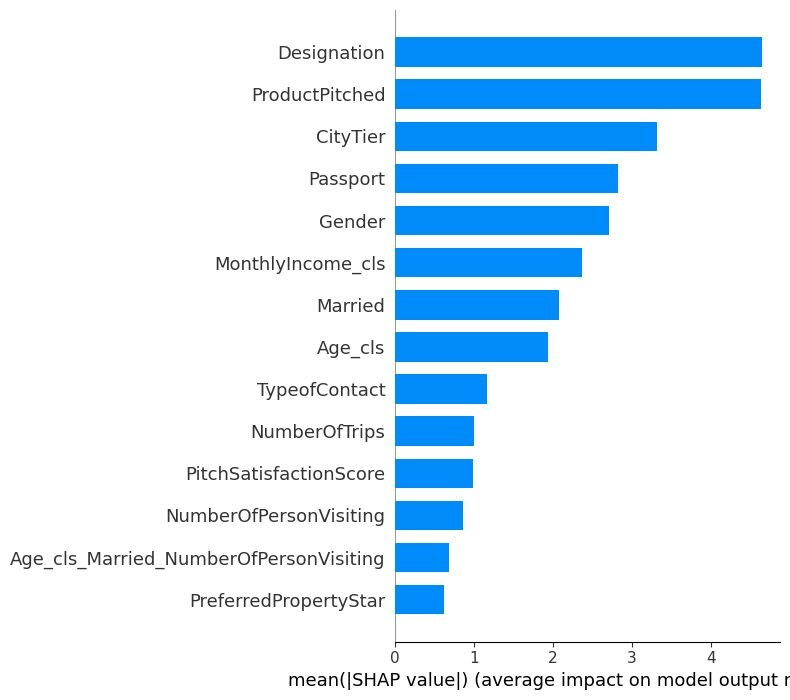

In [283]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
shap.initjs()

# 各FOLD、SEEDの和 (相対値なのでこれで良しとする)
shapval = 0
for i in range(3):
  for j in range(5):
    explainer = shap.TreeExplainer(models[i][j])
    shap_values = explainer.shap_values(X)
    shapval = shapval + shap_values

shap.summary_plot(shapval, X,plot_type="bar", max_display=50)